In [1]:
import pandas as pd
import numpy as np
import random
import matplotlib.pyplot as plt

%matplotlib inline

from sklearn.datasets import load_digits
from sklearn.metrics import r2_score
from sklearn.ensemble import RandomForestRegressor
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler
from sklearn import metrics

In [2]:
# Sampling 20,000 data entries
n = 767672 
s = 40000
skip = sorted(random.sample(range(1,n+1),n-s))
data = pd.read_csv('zeroopenpowerlifting.csv', skiprows=skip)
data

,Name,Sex,Event,Equipment,Age,AgeClass,Division,BodyweightKg,WeightClassKg,Squat1Kg,...,TotalKg,Place,Wilks,McCulloch,Glossbrenner,IPFPoints,Tested,Country,Federation,Date
0,Abbie Murphy,F,SBD,Wraps,29.0,24-34,F-OR,59.80,60,80.0,...,290.0,4,324.16,324.16,286.42,511.15,NaN,NaN,GPC-AUS,2018-10-27
1,Kylie Smith,F,SBD,Wraps,37.0,35-39,F-OR,60.00,60,75.0,...,247.5,6,275.93,275.93,243.80,432.42,NaN,NaN,GPC-AUS,2018-10-27
2,Lyndall Ablett,F,SBD,Wraps,45.0,45-49,F-OR,64.80,67.5,100.0,...,297.5,3,312.82,330.03,276.13,506.15,NaN,NaN,GPC-AUS,2018-10-27
3,Blake Nauta,M,SBD,Wraps,31.0,24-34,M-OR,94.60,100,170.0,...,495.0,13,308.49,308.49,296.94,436.17,NaN,NaN,GPC-AUS,2018-10-27
4,Griffin Spence,M,SBD,Raw,27.0,24-34,M-OR,67.10,67.5,165.0,...,535.0,1,414.47,414.47,402.10,612.11,NaN,NaN,GPC-AUS,2018-10-27
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
39995,Samantha Adee,F,SBD,Wraps,36.5,35-39,wsm2,70.76,75,0.0,...,352.5,1,348.10,348.10,306.76,578.89,Yes,USA,NASA,2019-05-18
39996,Dominic Frisillo,M,SBD,Wraps,21.5,20-23,jr,73.03,75,0.0,...,470.0,2,341.29,344.70,330.14,493.53,Yes,USA,NASA,2019-05-18
39997,Emmanuel Bernal,M,SBD,Wraps,28.0,24-34,int,89.90,90,0.0,...,510.0,1,325.77,325.77,312.23,467.69,Yes,USA,NASA,2019-05-18
39998,Britney Baker,F,SBD,Wraps,23.0,20-23,wopen,100.70,90+,0.0,...,462.5,1,384.29,384.29,329.84,656.56,Yes,USA,NASA,2019-10-19


In [3]:
# Dropping columns not needed for this test
data = data.drop(columns=['Name', 'AgeClass', 'Division',
                          'Squat4Kg', 'Bench4Kg', 'Deadlift4Kg',
                          'Place', 'Tested', 'Country', 'Federation',
                          'Date', 'IPFPoints', 'TotalKg', 'Squat1Kg',
                          'Squat2Kg', 'Squat3Kg','Bench1Kg', 'Bench2Kg',
                          'Bench3Kg', 'Deadlift1Kg', 'Deadlift2Kg',
                          'Deadlift3Kg', 'McCulloch', 'Glossbrenner',
                          'WeightClassKg'])

data.columns
data.isnull().sum()

Sex                   0
Event                 0
Equipment             0
Age                   0
BodyweightKg          0
Best3SquatKg          0
Best3BenchKg          0
Best3DeadliftKg       0
Wilks              2295
dtype: int64

In [4]:
# General dropna just  to clear those without a WILKS
data = data.dropna()

In [5]:
# Dropping athletes who did not compete in complete SBD competitions
indexNames = data[data['Event'] == 'S'].index
data.drop(indexNames, inplace=True)

indexNames = data[data['Event'] == 'B'].index
data.drop(indexNames, inplace=True)

indexNames = data[data['Event'] == 'D'].index
data.drop(indexNames, inplace=True)

indexNames = data[data['Event'] == 'SD'].index
data.drop(indexNames, inplace=True)

indexNames = data[data['Event'] == 'SB'].index
data.drop(indexNames, inplace=True)

indexNames = data[data['Event'] == 'BD'].index
data.drop(indexNames, inplace=True)
data

,Sex,Event,Equipment,Age,BodyweightKg,Best3SquatKg,Best3BenchKg,Best3DeadliftKg,Wilks
0,F,SBD,Wraps,29.0,59.80,105.0,55.0,130.0,324.16
1,F,SBD,Wraps,37.0,60.00,75.0,55.0,117.5,275.93
2,F,SBD,Wraps,45.0,64.80,110.0,57.5,130.0,312.82
3,M,SBD,Wraps,31.0,94.60,180.0,115.0,200.0,308.49
4,M,SBD,Raw,27.0,67.10,182.5,107.5,245.0,414.47
...,...,...,...,...,...,...,...,...,...
39993,M,SBD,Wraps,30.0,82.01,195.0,157.5,232.5,393.30
39995,F,SBD,Wraps,36.5,70.76,132.5,70.0,150.0,348.10
39996,M,SBD,Wraps,21.5,73.03,170.0,95.0,205.0,341.29
39997,M,SBD,Wraps,28.0,89.90,182.5,115.0,212.5,325.77


In [6]:
# Convert string data to numeric
sex = {'M': 1, 'F': 0, 'Mx': 3}
equipment = {'Raw': 0, 'Wraps': 1, 'Multi-ply': 2, 'Single-ply': 3, 'Straps': 4}

data.Sex = [sex[item] for item in data.Sex]
data.Equipment = [equipment[item] for item in data.Equipment]

In [7]:
# Normalise the data, scaling to values between 0-1
scaler = MinMaxScaler(feature_range=(0,1))
data[['Sex', 'Age', 'Equipment', 'BodyweightKg',
        'Wilks', 'Best3BenchKg', 'Best3DeadliftKg', 'Best3SquatKg']] = scaler.fit_transform(data[['Sex', 'Age', 'Equipment', 'BodyweightKg',
        'Wilks', 'Best3BenchKg', 'Best3DeadliftKg', 'Best3SquatKg']])

In [8]:
# So, running 3 different test and training sets.
# First for squats, then bench, finally deadlifts,
# See the model accuracy for predicting someone's lifts.
# Further experiments to see which variables are critical
# to accurate prediction. How accurate can we get with age,
# sex, weight, and equipment?

test_data = data[[ 'Sex', 'Age', 'BodyweightKg', 'Equipment', 'Wilks']]

target_squat = data[['Best3SquatKg']]

target_bench = data[['Best3BenchKg']]

target_dead = data[['Best3DeadliftKg']]

In [9]:
#Prepare the sets
X = test_data
s = target_squat
b = target_bench
d = target_dead

In [10]:
# Split sets into training and test sets
X_train, X_test, s_train, s_test = train_test_split(X, s, test_size=0.1, random_state=3)
X_train, X_test, b_train, b_test = train_test_split(X, b, test_size=0.1, random_state=3)
X_train, X_test, d_train, d_test = train_test_split(X, d, test_size=0.1, random_state=3)

In [11]:
# Prepare random forest model, check r2_scores.
rfregr = RandomForestRegressor(n_estimators=100, max_depth = 30)

In [12]:
rfregr.fit(X_train, s_train.values.ravel())

RandomForestRegressor(bootstrap=True, ccp_alpha=0.0, criterion='mse',
                      max_depth=30, max_features='auto', max_leaf_nodes=None,
                      max_samples=None, min_impurity_decrease=0.0,
                      min_impurity_split=None, min_samples_leaf=1,
                      min_samples_split=2, min_weight_fraction_leaf=0.0,
                      n_estimators=100, n_jobs=None, oob_score=False,
                      random_state=None, verbose=0, warm_start=False)

In [13]:
S_rfr = rfregr.predict(X_test)
print("R2-score: %.2f" % r2_score(S_rfr , s_test))

R2-score: 0.95


In [14]:
rfregr.fit(X_train, b_train.values.ravel())

RandomForestRegressor(bootstrap=True, ccp_alpha=0.0, criterion='mse',
                      max_depth=30, max_features='auto', max_leaf_nodes=None,
                      max_samples=None, min_impurity_decrease=0.0,
                      min_impurity_split=None, min_samples_leaf=1,
                      min_samples_split=2, min_weight_fraction_leaf=0.0,
                      n_estimators=100, n_jobs=None, oob_score=False,
                      random_state=None, verbose=0, warm_start=False)

In [15]:
B_rfr = rfregr.predict(X_test)
print("R2-score: %.2f" % r2_score(B_rfr , b_test))

R2-score: 0.89


In [16]:
rfregr.fit(X_train, d_train.values.ravel())

RandomForestRegressor(bootstrap=True, ccp_alpha=0.0, criterion='mse',
                      max_depth=30, max_features='auto', max_leaf_nodes=None,
                      max_samples=None, min_impurity_decrease=0.0,
                      min_impurity_split=None, min_samples_leaf=1,
                      min_samples_split=2, min_weight_fraction_leaf=0.0,
                      n_estimators=100, n_jobs=None, oob_score=False,
                      random_state=None, verbose=0, warm_start=False)

In [17]:
D_rfr = rfregr.predict(X_test)
print("R2-score: %.2f" % r2_score(D_rfr, d_test))

R2-score: 0.92


In [18]:
#Prepare Lineaar model and check r2_scores
linreg = LinearRegression()

In [19]:
linreg.fit(X_train, s_train.values.ravel())

LinearRegression(copy_X=True, fit_intercept=True, n_jobs=None, normalize=False)

In [20]:
S_lin = linreg.predict(X_test)
print("R2-score: %.2f" % r2_score(S_lin, s_test))

R2-score: 0.92


In [21]:
linreg.fit(X_train, b_train.values.ravel())

LinearRegression(copy_X=True, fit_intercept=True, n_jobs=None, normalize=False)

In [22]:
B_lin = linreg.predict(X_test)
print("R2-score: %.2f" % r2_score(B_lin , b_test))

R2-score: 0.85


In [23]:
linreg.fit(X_train, d_train.values.ravel())

LinearRegression(copy_X=True, fit_intercept=True, n_jobs=None, normalize=False)

In [24]:
D_lin = linreg.predict(X_test)
print("R2-score: %.2f" % r2_score(D_lin , d_test))

R2-score: 0.89


In [25]:
s_pred = pd.DataFrame(linreg.predict(X_test))
S_bw = pd.DataFrame(X_test['BodyweightKg'])
S_bw = S_bw.reset_index()
s_pred = s_pred.reset_index()
S_bw = S_bw.drop(columns = 'index')
s_pred = s_pred.drop(columns = 'index')
s_t = s_test.reset_index()
s_t = s_t.drop(columns = 'index')

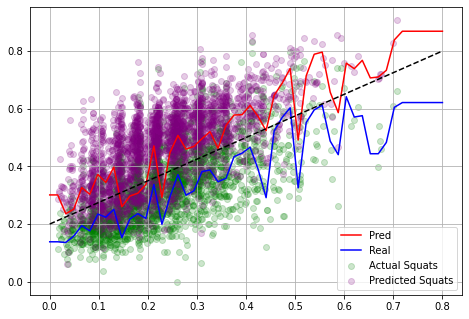

In [26]:
xfit = np.linspace(0, 0.8)
yfit = RandomForestRegressor().fit(S_bw, s_pred.values.ravel()).predict(xfit[:, None])
zfit = RandomForestRegressor().fit(S_bw, s_test.values.ravel()).predict(xfit[:, None])
fig = plt.figure()
ax = fig.add_axes([0,0,1,1])
ax.scatter(S_bw, s_test, color = 'g', label='Actual Squats', alpha=0.2)
ax.scatter(S_bw, s_pred, color = 'purple', label='Predicted Squats', alpha=0.2)
plt.plot(xfit, yfit, 'r', label='Pred')
plt.plot(xfit, zfit, 'b', label='Real')
plt.plot([0,0.8], [0.2,0.8], 'k--')
ax.legend()
ax.grid(True)
plt.show()

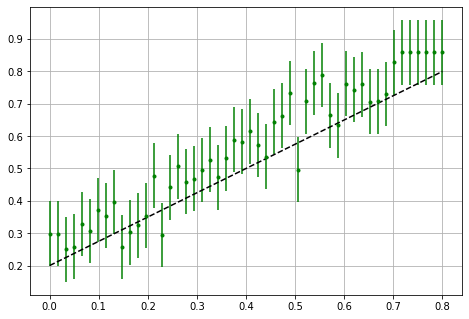

In [27]:
xfit = np.linspace(0, 0.8)
yfit = RandomForestRegressor().fit(S_bw, s_pred.values.ravel()).predict(xfit[:, None])
zfit = RandomForestRegressor().fit(S_bw, s_test.values.ravel()).predict(xfit[:, None])
fig = plt.figure()
ax = fig.add_axes([0,0,1,1])
plt.errorbar(xfit, yfit, 0.1, fmt='.g')
plt.plot([0,0.8], [0.2,0.8], 'k--')
ax.grid(True)
plt.show()

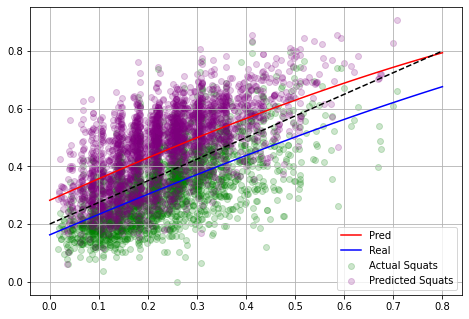

In [28]:
xfit = np.linspace(0, 0.8)
yfit = LinearRegression().fit(S_bw, s_pred).predict(xfit[:, None])
zfit = LinearRegression().fit(S_bw, s_test).predict(xfit[:, None])
fig = plt.figure()
ax = fig.add_axes([0,0,1,1])
ax.scatter(S_bw, s_test, color = 'g', label='Actual Squats', alpha=0.2)
ax.scatter(S_bw, s_pred, color = 'purple', label='Predicted Squats', alpha=0.2)
#plt.plot(xfit, yfit, '-r', color='red', label='Pred')
#plt.plot(xfit, zfit, '-r', color='blue', label='Real')
ax.plot(xfit, np.sin(yfit), color = 'r', label='Pred');
ax.plot(xfit, np.sin(zfit), color = 'b', label='Real');
plt.plot([0,0.8], [0.2,0.8], 'k--')
ax.legend()
ax.grid(True)
plt.show()